# Stock Data Preprocessing

### Adding Project path to Sys Path

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
notebook_dir = os.getcwd()
parent_path=os.path.dirname(notebook_dir)

os.chdir(parent_path)

### Load Modules

In [2]:
from script.Preprocessing import Preprocessor
processor=Preprocessor()

### Download Stock Price Historical Data from Yahoo Finance
The following historical financial data for three key assets are fetched using `yfinance`
- **Tesla (TSLA) Historical stock prices**
- **Vanguard Total Bond Market ETF (BND)**
- **S&P 500 ETF (SPY)**

In [3]:
processor.dload_save_yfinance_data(tickers=['TSLA','BND','SPY'])

#Load the data from the saved csv
import pandas as pd
stoke_data=pd.read_csv("data/stoke_data.csv")
stoke_data.set_index('Date',inplace=True)
stoke_data.index=pd.to_datetime(stoke_data.index)
stoke_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,TSLA,BND,SPY
Date,,,
2015-01-02,14.620667,82.650002,205.429993
2015-01-05,14.006000,82.889999,201.720001
2015-01-06,14.085333,83.129997,199.820007
2015-01-07,14.063333,83.180000,202.309998
2015-01-08,14.041333,83.050003,205.899994


### Check missing Values

In [4]:
processor.check_missing(stoke_data)

## Exploratory Data Analysis (EDA)

### Closing Price Over Time

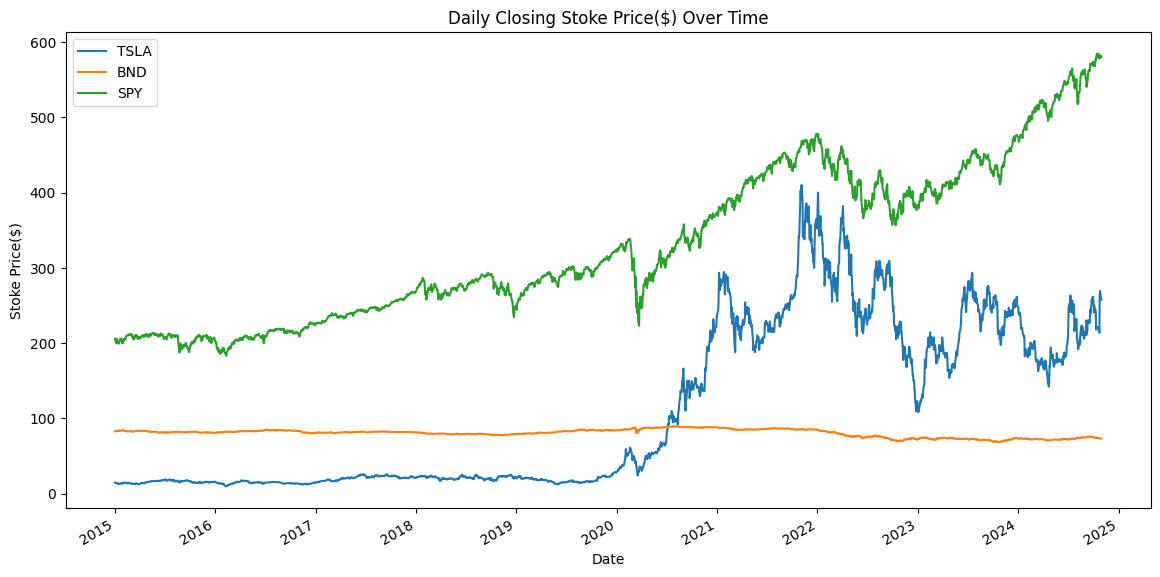

In [ ]:
processor.timeseries_plot(stoke_data)

### Daily Percentage Return 

In [ ]:
processor.return_distribution(stoke_data)

### Rolling means and standard deviations
In stoke market trading the week only comprise**5 days** . So to calculate rolling means and standard deviation we use:
- **Weekly:** 5 days
- **Monthly:** ~ 21  days
- **Yearly:** ~ 252 days

In [ ]:
processor.rolling_mean_std(stoke_data)

### Outlier Detection
`zscore` is used to identify the outliers.Here is the criteria:
$$outlier : zscore > |2|$$


In [ ]:
Preprocessor.outliers_plot(stoke_data)

### Seasonality and Trends

In [ ]:
processor.seasonal_decompose(stoke_data)

### VaR and Sharpe Ratio
**Value at Risk (VaR)** measures the maximum potential loss an asset or portfolio could face over a given time horizon at a specified confidence level. It helps assess the risk of losing more than a certain amount over a certain period.<br>

For a given confidence level α (say 95%) over a time period `t`:
$$
\text{VaR}_{\alpha} = \text{Quantile}_{1-\alpha}(\text{Portfolio Returns})
$$



In [ ]:
processor.var_ratio(stoke_data)

**Sharpe Ratio**

The Sharpe Ratio is a measure of the risk-adjusted return of an asset or portfolio. It calculates the excess return per unit of risk, which helps to compare the risk-adjusted performance of different investments.
$$
Sharp Ratio= \frac{R_p-R_f}{R_\sigma} \\

Where: \\
R_p: \text{Expected portfolio return} \\
R_f: \text{Risk-free rate of return} \\
R_\sigma: \text{Standard deviation of the portfolio returns}
$$

In [ ]:
processor.sharpe_ratio(stoke_data)

TSLA Sharpe Ratio: 0.04467250513528375
BND Sharpe Ratio: -0.07052294239936706
SPY Sharpe Ratio: 0.025274903130920536
